# 03 Appendix: Experiments with pre-defined splits

We saw how different combinations of models could create synthetic data with bettwe trade-off between utility and privacy.

In this notebook we try some of the less obvious combinations of models and generate some of the figures seen in the appendix of the paper.

In [1]:
### Imports
import pandas as pd

from pandas import DataFrame
from typing import List, Dict

from joblib import Parallel, delayed

from syntheval import SynthEval

from sklearn.ensemble import RandomForestClassifier
from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator, Concatenating
from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data

### Constants
NUM_REPS = 10

### Metrics
metrics = {
    "pca"       : {},
    "h_dist"    : {},
    "corr_diff" : {"mixed_corr": True},
    "auroc_diff" : {"model": "rf_cls"},
    "cls_acc"   : {"F1_type": "macro"},
    "eps_risk"  : {},
    "dcr"       : {},
    "mia"  : {"num_eval_iter": 5},
}

In [2]:
### Load training and testing datasets and define categorical and numerical attributes

df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]

print(cat_atts)
print(num_atts)

df_train.head()

['WBC', 'RBC', 'Plat', 'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF', 'Gender', 'Fever', 'Nausea/Vomting', 'Headache', 'Diarrhea', 'Fatigue & generalized bone ache', 'Jaundice', 'Epigastric pain', 'b_class']
['Age', 'BMI', 'HGB', 'AST 1', 'ALT 1', 'ALT 4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w', 'Baseline histological Grading']


,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,b_class
0,47,2,32,2,2,1,2,2,2,2,...,87,56,39,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",11,1
1,36,2,24,2,1,2,2,2,1,2,...,108,74,45,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",3,1
2,50,1,34,1,1,2,1,2,2,2,...,71,125,28,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",9,1
3,32,2,30,1,2,1,2,2,1,1,...,102,84,40,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",6,0
4,58,1,29,2,2,1,1,2,2,1,...,55,40,40,"(5, 1201086]","(5, 1201715]","(0, 5]","(0, 5]","(0, 5]",15,1


## baseline models with themselves (validated)

In [ ]:
def _single_mixed_model_experiment(df_train: DataFrame, gms: List[str], parts: Dict[str, List[str]], id) -> DataFrame:
    """ Function to do runs of the mixed model. """

    Rf = RandomForestClassifier(n_estimators=100)
    JS = UsingJoiningValidator(JoiningValidator(Rf, verbose=False, calibration_method='sigmoid'), behaviour='adaptive')

    dgms = DisjointGenerativeModels(df_train, gms, parts, joining_strategy=JS, worker_id=id*10)
    dgms.join_multiplier = 4    # to ensure high enough resolution

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           cat_atts: List[str], num_atts: List[str], label: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = [model1, model2]
    parts = {'part1': cat_atts, 'part2': num_atts}
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, parts, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'synthpop', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_synthpop.csv')
#~30 secs

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'datasynthesizer', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_datasynthesizer.csv')
#~9 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'ctgan', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_ctgan.csv')
#~20 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'adsgan', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_adsgan.csv')
#~22 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'dpgan', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_dpgan.csv')
#~14 mins

In [ ]:
### Read all the results and present them in a joint dataframe
res_dfs = {
    'sp_sp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_synthpop.csv', index_col=0),
    'ds_ds': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_datasynthesizer.csv', index_col=0),
    'ct_ct': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_ctgan.csv', index_col=0),
    'ad_ad': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_adsgan.csv', index_col=0),
    'dp_dp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_dpgan.csv', index_col=0),
}

### Create a joint dataframe with all the results
df_results = pd.concat(res_dfs, axis=1)
df_results.T

pca_eigval_diff  pca_eigvec_ang  avg_h_dist  corr_mat_diff  \
sp_sp mean         0.038524        0.610445    0.013677       0.552313   
      sem          0.001821        0.065177    0.001283       0.019113   
ds_ds mean         0.030376        0.775333    0.014495       0.531190   
      sem          0.002166        0.049899    0.001276       0.017726   
ct_ct mean         0.041689        0.640330    0.023124       0.871069   
      sem          0.001993        0.038338    0.001258       0.013215   
ad_ad mean         0.047619        0.594839    0.021214       0.836909   
      sem          0.002103        0.071774    0.001130       0.019295   
dp_dp mean         0.281217        0.742197    0.208961       2.886076   
      sem          0.019597        0.087687    0.005612       0.106393   

               auroc  avg_F1_diff  avg_F1_diff_hout  eps_identif_risk  \
sp_sp mean  0.010769    -0.076845         -0.000981          0.582986   
      sem   0.016534     0.003373          0.002485          0.003243   
ds_ds mean -0.009816    -0.089008         -0.007976          0.582986   
      sem   0.009276     0.002837          0.003250          0.008500   
ct_ct mean  0.022548    -0.057924          0.017377          0.487692   
      sem   0.012113     0.004934          0.007269          0.003985   
ad_ad mean -0.021810    -0.049628          0.021121          0.491855   
      sem   0.007460     0.004676          0.005617          0.005764   
dp_dp mean  0.005793    -0.261602         -0.199803          0.038552   
      sem   0.010177     0.017569          0.011467          0.007598   

            priv_loss_eps  median_DCR  mia_recall  mia_precision  
sp_sp mean       0.386606    0.924876    0.473043       0.539927  
      sem        0.003037    0.002939    0.009504       0.007962  
ds_ds mean       0.382715    0.934368    0.458261       0.514138  
      sem        0.008051    0.002850    0.011188       0.005616  
ct_ct mean       0.289593    1.027419    0.283768       0.490968  
      sem        0.003849    0.004946    0.011558       0.008198  
ad_ad mean       0.291855    1.023196    0.337101       0.505631  
      sem        0.004621    0.002857    0.011587       0.012245  
dp_dp mean       0.014751    1.892072    0.002899       0.180000  
      sem        0.003426    0.021814    0.000748       0.048990

## baseline models with themselves (concat)


In [3]:
def _single_mixed_model_experiment(df_train: DataFrame, gms: List[str], parts: Dict[str, List[str]], id) -> DataFrame:
    """ Function to do runs of the mixed model. """
    JS = Concatenating()

    dgms = DisjointGenerativeModels(df_train, gms, parts, joining_strategy=JS, worker_id=id*10)
    dgms.join_multiplier = 4    # to ensure high enough resolution

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           cat_atts: List[str], num_atts: List[str], label: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = [model1, model2]
    parts = {'part1': cat_atts, 'part2': num_atts}
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, parts, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'synthpop', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_synthpop_concat.csv')
#~30 secs

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'datasynthesizer', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_datasynthesizer_concat.csv')
#~10 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'ctgan', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_ctgan_concat.csv')
#~25 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'adsgan', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_adsgan_concat.csv')
#~45 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'dpgan', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_dpgan_concat.csv')
#~15 mins

In [6]:
### Read all the results and present them in a joint dataframe
res_dfs = {
    'sp_sp_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_synthpop_concat.csv', index_col=0),
    'ds_ds_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_datasynthesizer_concat.csv', index_col=0),
    'ct_ct_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_ctgan_concat.csv', index_col=0),
    'ad_ad_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_adsgan_concat.csv', index_col=0),
    'dp_dp_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_dpgan_concat.csv', index_col=0),
}

### Create a joint dataframe with all the results
df_results = pd.concat(res_dfs, axis=1)
df_results.T

pca_eigval_diff  pca_eigvec_ang  avg_h_dist  corr_mat_diff  \
sp_sp_c mean         0.020139        0.304645    0.006218       0.389991   
        sem          0.001236        0.025514    0.000377       0.013017   
ds_ds_c mean         0.012815        0.587791    0.006014       0.401502   
        sem          0.000814        0.074937    0.000409       0.011000   
ct_ct_c mean         0.031167        0.425021    0.017515       0.660217   
        sem          0.001547        0.034791    0.001688       0.017100   
ad_ad_c mean         0.037137        0.569346    0.016528       0.680929   
        sem          0.002089        0.057956    0.001183       0.013223   
dp_dp_c mean         0.248034        0.761038    0.209479       2.854064   
        sem          0.020942        0.052310    0.004345       0.050275   

                 auroc  avg_F1_diff  avg_F1_diff_hout  eps_identif_risk  \
sp_sp_c mean  0.031032    -0.085406         -0.006971          0.604887   
        sem   0.010474     0.002197          0.003269          0.003521   
ds_ds_c mean -0.001177    -0.083557         -0.008994          0.610588   
        sem   0.006399     0.001566          0.003689          0.006069   
ct_ct_c mean  0.009923    -0.075838          0.003995          0.505520   
        sem   0.012482     0.005646          0.005815          0.003193   
ad_ad_c mean  0.004593    -0.071984          0.001949          0.512670   
        sem   0.009485     0.004102          0.004410          0.004382   
dp_dp_c mean  0.010504    -0.230313         -0.139214          0.029774   
        sem   0.011295     0.031062          0.029866          0.003710   

              priv_loss_eps  median_DCR  mia_recall  mia_precision  
sp_sp_c mean       0.404706    0.959375    0.526087       0.528839  
        sem        0.003694    0.002395    0.007537       0.008366  
ds_ds_c mean       0.407421    0.980109    0.508116       0.512933  
        sem        0.005885    0.001747    0.003642       0.003902  
ct_ct_c mean       0.304977    1.017191    0.316812       0.489060  
        sem        0.002701    0.003945    0.008887       0.007809  
ad_ad_c mean       0.308959    1.019598    0.357971       0.504815  
        sem        0.004557    0.002793    0.007399       0.003166  
dp_dp_c mean       0.006425    1.924221    0.002029       0.120000  
        sem        0.001709    0.013708    0.001147       0.061101

## Hellinger Distance Histograms

We will show the histograms of the Hellinger distance between the baseline, concatenation and validated join results.

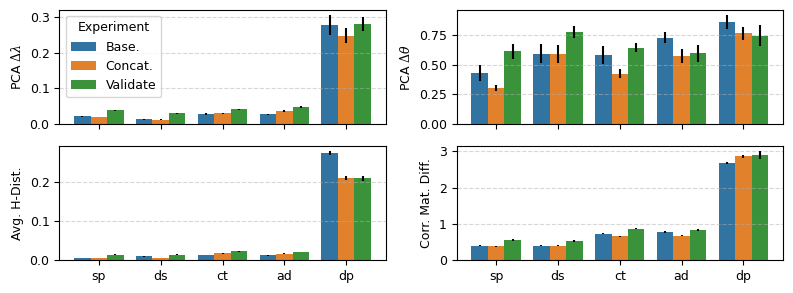

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 9, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

### Read all the results and present them in a joint dataframe
res_dfs = {
    'sp_b': pd.read_csv('experiments/results/hepatitis_case_study_adapt/synthpop.csv', index_col=0),
    'ds_b': pd.read_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer.csv', index_col=0),
    'ct_b': pd.read_csv('experiments/results/hepatitis_case_study_adapt/ctgan.csv', index_col=0),
    'ad_b': pd.read_csv('experiments/results/hepatitis_case_study_adapt/adsgan.csv', index_col=0),
    'dp_b': pd.read_csv('experiments/results/hepatitis_case_study_adapt/dpgan.csv', index_col=0),
    'sp_sp_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_synthpop_concat.csv', index_col=0),
    'ds_ds_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_datasynthesizer_concat.csv', index_col=0),
    'ct_ct_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_ctgan_concat.csv', index_col=0),
    'ad_ad_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_adsgan_concat.csv', index_col=0),
    'dp_dp_c': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_dpgan_concat.csv', index_col=0),
    'sp_sp_v': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_synthpop.csv', index_col=0),
    'ds_ds_v': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_datasynthesizer.csv', index_col=0),
    'ct_ct_v': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_ctgan.csv', index_col=0),
    'ad_ad_v': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_adsgan.csv', index_col=0),
    'dp_dp_v': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_dpgan.csv', index_col=0),
}

df_results = pd.concat(res_dfs, axis=1)

metrics_to_show = {
    'pca_eigval_diff': r"PCA $\Delta\lambda$",
    'pca_eigvec_ang': r"PCA $\Delta\theta$",
    'avg_h_dist': 'Avg. H-Dist.',
    'corr_mat_diff': 'Corr. Mat. Diff.',
}

### separate out mean and sem values
mean_results = df_results.xs('mean', axis=1, level=1).T
sem_results = df_results.xs('sem', axis=1, level=1).T

fig, axes = plt.subplots(2, 2, figsize=(8, 3), sharex=True)
axes = axes.flatten()
for i, metric in enumerate(metrics_to_show.keys()):
    means = mean_results[metric] 
    sems = sem_results[metric] 

    df_temp = pd.concat([means, sems], axis=1, keys=['mean', 'sem'])

    df_temp['model'] = df_temp.index.str.split('_').str[0]
    df_temp['series'] = df_temp.index.str.split('_').str[-1]

    sns.barplot(x='model', y='mean', hue='series', data=df_temp.reset_index(), ax=axes[i])
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in axes[i].patches if p.get_height() != 0]
    y_coords = [p.get_height() for p in axes[i].patches if p.get_height() != 0]
    axes[i].errorbar(x=x_coords, y=y_coords, yerr=df_temp["sem"].values[:len(y_coords)], fmt="none", c="k")
    axes[i].set_ylabel(metrics_to_show[metric])
    axes[i].set_xlabel('')

    axes[i].get_legend().remove()
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles, labels=['Base.', 'Concat.', 'Validate'], title='Experiment', loc='upper left')

plt.tight_layout()
plt.savefig('experiments/figures/figureA1_stat_mets.pdf', dpi=300, bbox_inches='tight')

## Random Partitions with mixed-models (validated)

Here we try the same six combinations of models as in the previous notebook, but we use the random partitions instead of the pre-defined splits. To keep the premisis of the paper, we use the same size of partitions as in the pre-defined splits (though now randomly selected). I.e.

"part1": 17 features, 
"part2": 12 features

In [13]:
def _single_mixed_model_experiment(df_train: DataFrame, gms: List[str], parts: Dict[str, List[str]], id) -> DataFrame:
    """ Function to do runs of the mixed model. """

    Rf = RandomForestClassifier(n_estimators=100)
    JS = UsingJoiningValidator(JoiningValidator(Rf, verbose=False, calibration_method='sigmoid'), behaviour='adaptive')

    dgms = DisjointGenerativeModels(df_train, gms, parts, joining_strategy=JS, worker_id=id*10)
    dgms.join_multiplier = 4    # to ensure high enough resolution

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           cat_atts: List[str], num_atts: List[str], label: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = [model1, model2]
    parts = {'part1': len(cat_atts), 'part2': len(num_atts)}    # The change of changing this from a list of features to an integer makes the model sample the features
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, parts, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_ctgan_random.csv')
#~11 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_adsgan_random.csv')
#~11 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_dpgan_random.csv')
#~7 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_ctgan_random.csv')
#~16 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_adsgan_random.csv')
#~16 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_dpgan_random.csv')
#~13 mins

In [17]:
### Read all the results and present them in a joint dataframe
res_dfs = {
    'sp_ct_r': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_ctgan_random.csv', index_col=0),
    'sp_ad_r': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_adsgan_random.csv', index_col=0),
    'sp_dp_r': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_dpgan_random.csv', index_col=0),
    'ds_ct_r': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_ctgan_random.csv', index_col=0),
    'ds_ad_r': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_adsgan_random.csv', index_col=0),
    'ds_dp_r': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_dpgan_random.csv', index_col=0),
}

### Create a joint dataframe with all the results
df_results = pd.concat(res_dfs, axis=1)
df_results.T

pca_eigval_diff  pca_eigvec_ang  avg_h_dist  corr_mat_diff  \
sp_ct_r mean         0.047665        0.575365    0.015600       0.644970   
        sem          0.002990        0.052573    0.001112       0.032146   
sp_ad_r mean         0.046019        0.639164    0.015869       0.689708   
        sem          0.002198        0.096246    0.001010       0.050821   
sp_dp_r mean         0.227492        0.657098    0.135880       1.659429   
        sem          0.033228        0.065580    0.008008       0.216547   
ds_ct_r mean         0.041387        0.713253    0.015625       0.653333   
        sem          0.002886        0.062920    0.000949       0.044444   
ds_ad_r mean         0.041175        0.632231    0.015316       0.615581   
        sem          0.003012        0.076794    0.001887       0.027177   
ds_dp_r mean         0.263551        0.798516    0.130122       1.839184   
        sem          0.019052        0.048897    0.007406       0.206171   

                 auroc  avg_F1_diff  avg_F1_diff_hout  eps_identif_risk  \
sp_ct_r mean -0.001285    -0.086864         -0.008846          0.558914   
        sem   0.010720     0.003324          0.002409          0.004357   
sp_ad_r mean -0.002715    -0.080427         -0.009398          0.557557   
        sem   0.010476     0.004010          0.002034          0.006203   
sp_dp_r mean  0.030673    -0.140573         -0.062249          0.223982   
        sem   0.009993     0.034122          0.032868          0.032424   
ds_ct_r mean -0.015893    -0.083539         -0.007627          0.575113   
        sem   0.009816     0.003394          0.002669          0.005586   
ds_ad_r mean  0.004451    -0.074755         -0.000213          0.557285   
        sem   0.009940     0.003648          0.001955          0.006694   
ds_dp_r mean  0.021262    -0.170076         -0.071533          0.186244   
        sem   0.008011     0.038560          0.032586          0.032929   

              priv_loss_eps  median_DCR  mia_recall  mia_precision  
sp_ct_r mean       0.361176    0.948486    0.389565       0.527727  
        sem        0.003843    0.004425    0.014648       0.007706  
sp_ad_r mean       0.358190    0.954479    0.394493       0.523712  
        sem        0.005760    0.005316    0.013789       0.009838  
sp_dp_r mean       0.129231    1.331135    0.012754       0.360000  
        sem        0.019833    0.055506    0.004238       0.081945  
ds_ct_r mean       0.373484    0.948324    0.392754       0.512485  
        sem        0.005116    0.004024    0.008156       0.005911  
ds_ad_r mean       0.360905    0.955483    0.365797       0.509319  
        sem        0.006628    0.003688    0.010565       0.007702  
ds_dp_r mean       0.108778    1.377639    0.006087       0.293333  
        sem        0.021666    0.041668    0.001954       0.066999

In [5]:
### Check if random is significantly better or worse than deliberate

import numpy as np
from scipy.stats import norm

models_to_check = ['datasynthesizer_ctgan', 'datasynthesizer_adsgan', 'datasynthesizer_dpgan', 'synthpop_ctgan', 'synthpop_adsgan', 'synthpop_dpgan']

for model in models_to_check:
    print(model)
    
    res_cat_nums = pd.read_csv(f'experiments/results/hepatitis_case_study_adapt/{model}.csv', index_col=0)
    res_random = pd.read_csv(f'experiments/results/hepatitis_case_study_adapt/appendix_results/{model}_random.csv', index_col=0)

    # calculate percentage difference
    res_diff = (res_random['mean'] -res_cat_nums['mean']) / res_cat_nums['mean'] * 100

    # calculate the z-score for the difference
    z_score = (res_random['mean'] - res_cat_nums['mean']) / np.sqrt(res_cat_nums['sem']**2+res_random['sem']**2)

    # get p-values
    p_values = 2 * (1 - norm.cdf(np.abs(z_score)))
    p_values = pd.Series(p_values, index=res_cat_nums.index)

    res = pd.concat([res_cat_nums['mean'], res_random['mean'], res_diff, z_score, p_values], axis=1, keys=['cat_nums', 'random', 'diff %', 'z_score', 'p_value'])
    print(res)

datasynthesizer_ctgan
                  cat_nums    random      diff %   z_score       p_value
pca_eigval_diff   0.037540  0.041387   10.247857  1.142727  2.531521e-01
pca_eigvec_ang    0.604613  0.713253   17.968483  1.172271  2.410881e-01
avg_h_dist        0.017378  0.015625  -10.086768 -1.107230  2.681943e-01
corr_mat_diff     0.576554  0.653333   13.316912  1.539296  1.237319e-01
auroc             0.003419 -0.015893 -564.858325 -1.029656  3.031715e-01
avg_F1_diff      -0.080962 -0.083539    3.182951 -0.505880  6.129407e-01
avg_F1_diff_hout -0.009090 -0.007627  -16.099343  0.459445  6.459148e-01
eps_identif_risk  0.510045  0.575113   12.757275  8.724218  0.000000e+00
priv_loss_eps     0.307692  0.373484   21.382353  9.135124  0.000000e+00
median_DCR        0.945662  0.948324    0.281555  0.475875  6.341637e-01
mia_recall        0.322029  0.392754   21.962196  6.292134  3.131300e-10
mia_precision     0.512506  0.512485   -0.004010 -0.001986  9.984155e-01
datasynthesizer_adsgan
      

## Specified Partitions with mixed-models (concat)

Here we try the six combinations from the paper with concatenation instead of validated join. We use the same partitions.

In [3]:
def _single_mixed_model_experiment(df_train: DataFrame, gms: List[str], parts: Dict[str, List[str]], id) -> DataFrame:
    """ Function to do runs of the mixed model. """
    JS = Concatenating()

    dgms = DisjointGenerativeModels(df_train, gms, parts, joining_strategy=JS, worker_id=id*10)
    dgms.join_multiplier = 4    # to ensure high enough resolution

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           cat_atts: List[str], num_atts: List[str], label: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = [model1, model2]
    parts = {'part1': cat_atts, 'part2': num_atts}
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, parts, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop','ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_ctgan_concat.csv')
#~9 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_adsgan_concat.csv')
#~6 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/synthpop_dpgan_concat.csv')
#~7 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_ctgan_concat.csv')
#~14 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/datasynthesizer_adsgan_concat.csv')
#~13 mins

================ Constructing Bayesian Network (BN) ================
Adding ROOT Diarrhea
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA 4
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA Base
================ Constructing Bayesian Network (BN) ================
Adding ROOT Epigastric pain
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA EOT
================ Constructing Bayesian Network (BN) ================
Adding ROOT Fever
================ Constructing Bayesian Network (BN) ================
Adding ROOT RBC
================ Constructing Bayesian Network (BN) ================
Adding ROOT Fever
================ Constructing Bayesian Network (BN) ================
Adding ROOT Gender
================ Constructing Bayesian Network (BN) ================
Adding ROOT Jaundice


[2025-03-31T15:14:41.233724+0200][2426938][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-03-31T15:14:41.607598+0200][2426935][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-03-31T15:14:41.998141+0200][2426945][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-03-31T15:14:42.182715+0200][2426936][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-03-31T15:14:43.084418+0200][2426943][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-03-31T15:14:43.416130+0200][2426939][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-03-31T15:1

Adding attribute RNA EF


[2025-03-31T15:14:47.240170+0200][2426941][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute RNA 12


[2025-03-31T15:14:47.679236+0200][2426940][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Plat
Adding attribute WBC
Adding attribute RNA EOT
Adding attribute Gender
Adding attribute RNA 12
Adding attribute WBC
Adding attribute b_class
Adding attribute WBC
Adding attribute RNA EF


  0%|          | 0/10000 [00:00<?, ?it/s]

Adding attribute Jaundice
Adding attribute Fatigue & generalized bone ache
Adding attribute WBC


  0%|          | 0/10000 [00:00<?, ?it/s]

Adding attribute RNA 12
Adding attribute RNA EOT
Adding attribute RNA 12
Adding attribute Nausea/Vomting
Adding attribute RNA EOT


  0%|          | 1/10000 [00:08<22:16:32,  8.02s/it]

Adding attribute Plat


  0%|          | 12/10000 [00:16<2:28:16,  1.12it/s]

Adding attribute RNA 12
Adding attribute RNA EF


  0%|          | 13/10000 [00:17<2:15:01,  1.23it/s]

Adding attribute Plat


  0%|          | 7/10000 [00:16<3:47:49,  1.37s/it]]

Adding attribute Jaundice


  0%|          | 17/10000 [00:20<2:10:16,  1.28it/s]

Adding attribute Diarrhea


  0%|          | 13/10000 [00:20<2:00:11,  1.38it/s]

Adding attribute RNA 4


  0%|          | 15/10000 [00:21<1:56:35,  1.43it/s]

Adding attribute Plat


  0%|          | 15/10000 [00:22<1:18:38,  2.12it/s]

Adding attribute RNA EOT


  0%|          | 2/10000 [00:01<2:09:49,  1.28it/s]]

Adding attribute RNA EF


  0%|          | 3/10000 [00:12<9:33:48,  3.44s/it] 

Adding attribute Headache


  0%|          | 20/10000 [00:34<4:23:42,  1.59s/it]]

Adding attribute Headache


  0%|          | 7/10000 [00:18<5:14:47,  1.89s/it]] 

Adding attribute RNA 4


  0%|          | 24/10000 [00:41<4:45:30,  1.72s/it]

Adding attribute Headache


  0%|          | 32/10000 [00:31<4:41:00,  1.69s/it]

Adding attribute Gender


  0%|          | 41/10000 [00:43<1:50:18,  1.50it/s]

Adding attribute RNA EF


  0%|          | 40/10000 [00:44<1:37:54,  1.70it/s]]

Adding attribute Jaundice


  0%|          | 34/10000 [00:35<5:33:33,  2.01s/it]

Adding attribute Plat


  0%|          | 42/10000 [00:54<7:36:56,  2.75s/it]]

Adding attribute RNA 4


  0%|          | 21/10000 [00:36<1:43:27,  1.61it/s]]

Adding attribute Gender


  0%|          | 17/10000 [00:35<3:42:07,  1.34s/it] 

Adding attribute Gender


  0%|          | 48/10000 [00:59<2:29:43,  1.11it/s] 

Adding attribute RNA 12


  0%|          | 25/10000 [00:55<3:22:47,  1.22s/it]]

Adding attribute Epigastric pain


  1%|          | 57/10000 [01:07<1:10:12,  2.36it/s]]

Adding attribute RNA 12
Adding attribute RNA 12


  1%|          | 60/10000 [01:08<1:25:20,  1.94it/s] 

Adding attribute Headache


  1%|          | 62/10000 [01:10<1:41:32,  1.63it/s]

Adding attribute RNA 4


  1%|          | 59/10000 [01:06<3:18:47,  1.20s/it]]

Adding attribute Fever


  0%|          | 35/10000 [00:58<2:20:33,  1.18it/s]]

Adding attribute Epigastric pain


  0%|          | 33/10000 [01:05<3:51:55,  1.40s/it]]

Adding attribute RNA EOT


  0%|          | 29/10000 [01:09<6:03:43,  2.19s/it]

Adding attribute Epigastric pain


  1%|          | 75/10000 [01:32<2:45:08,  1.00it/s]]

Adding attribute Gender


  0%|          | 33/10000 [01:13<6:38:45,  2.40s/it]]

Adding attribute Plat


  1%|          | 85/10000 [01:28<5:34:34,  2.02s/it]

Adding attribute RNA EOT


  1%|          | 87/10000 [01:30<4:37:43,  1.68s/it]]

Adding attribute Plat


  0%|          | 36/10000 [01:18<4:44:40,  1.71s/it] 

Adding attribute RNA 12


  1%|          | 100/10000 [01:37<1:31:44,  1.80it/s]

Adding attribute RNA EOT


  0%|          | 29/10000 [01:13<16:40:07,  6.02s/it]

Adding attribute Plat


  1%|          | 112/10000 [01:43<1:28:28,  1.86it/s]

Adding attribute Plat


  0%|          | 47/10000 [01:32<2:51:33,  1.03s/it]

Adding attribute RNA EF


  1%|          | 61/10000 [01:59<2:27:53,  1.12it/s]]

Adding attribute WBC


  0%|          | 32/10000 [01:21<10:28:50,  3.79s/it]

Adding attribute WBC


  1%|▏         | 130/10000 [02:06<2:31:17,  1.09it/s]

Adding attribute Epigastric pain


  1%|          | 109/10000 [02:18<1:52:53,  1.46it/s]

Adding attribute RNA EF


  1%|▏         | 133/10000 [02:09<2:47:12,  1.02s/it]

Adding attribute RNA EOT


  1%|          | 109/10000 [02:20<2:06:51,  1.30it/s]

Adding attribute WBC


  1%|          | 59/10000 [02:11<12:41:00,  4.59s/it]

Adding attribute RNA 4


  1%|          | 72/10000 [02:25<2:49:19,  1.02s/it]]

Adding attribute Fatigue & generalized bone ache


  1%|          | 116/10000 [02:24<1:35:59,  1.72it/s]

Adding attribute WBC


  1%|          | 63/10000 [02:17<5:56:02,  2.15s/it]]

Adding attribute Jaundice


  1%|          | 51/10000 [02:07<4:39:14,  1.68s/it]]

Adding attribute RNA EF


  1%|          | 70/10000 [02:28<4:48:00,  1.74s/it]]

Adding attribute Jaundice


  2%|▏         | 166/10000 [02:44<1:36:51,  1.69it/s]

Adding attribute WBC


  1%|          | 73/10000 [02:33<4:27:56,  1.62s/it]]

Adding attribute RNA EF
Adding attribute Jaundice
Adding attribute Epigastric pain
Adding attribute Jaundice


  1%|          | 52/10000 [02:18<5:29:47,  1.99s/it]]

Adding attribute RNA 4


  1%|          | 106/10000 [03:01<1:14:38,  2.21it/s]

Adding attribute Plat


  2%|▏         | 169/10000 [02:51<4:21:32,  1.60s/it]

Adding attribute Headache


  1%|          | 65/10000 [02:57<4:58:20,  1.80s/it]] 

Adding attribute RNA 4


  1%|▏         | 147/10000 [03:22<2:34:46,  1.06it/s]

Adding attribute Headache


  2%|▏         | 194/10000 [03:15<3:16:40,  1.20s/it]

Adding attribute b_class


  2%|▏         | 150/10000 [03:26<3:23:47,  1.24s/it]

Adding attribute Jaundice


  2%|▏         | 163/10000 [03:32<1:27:16,  1.88it/s] 

Adding attribute RNA 4


  1%|▏         | 131/10000 [03:13<2:38:11,  1.04it/s]

Adding attribute Headache


  1%|▏         | 132/10000 [03:13<2:07:46,  1.29it/s]

Adding attribute RNA 12


  1%|          | 72/10000 [03:19<5:27:45,  1.98s/it]]

Adding attribute Headache


  1%|          | 74/10000 [03:22<4:27:38,  1.62s/it]]

Adding attribute Epigastric pain


  1%|          | 68/10000 [03:02<3:51:37,  1.40s/it]]

Adding attribute Fatigue & generalized bone ache


  2%|▏         | 166/10000 [03:47<8:18:21,  3.04s/it] 

Adding attribute Diarrhea


  2%|▏         | 172/10000 [03:52<2:59:51,  1.10s/it]]

Adding attribute Headache


  2%|▏         | 182/10000 [04:01<3:21:03,  1.23s/it]]

Adding attribute RNA EOT


  1%|          | 76/10000 [03:38<4:52:49,  1.77s/it]]

Adding attribute Nausea/Vomting


  1%|          | 99/10000 [03:54<5:41:23,  2.07s/it]] 

Adding attribute Epigastric pain


  2%|▏         | 188/10000 [04:06<2:07:38,  1.28it/s]

Adding attribute Diarrhea


  2%|▏         | 224/10000 [03:57<10:13:21,  3.76s/it]

Adding attribute Epigastric pain


  2%|▏         | 190/10000 [04:08<2:31:32,  1.08it/s]

Adding attribute Nausea/Vomting


  1%|          | 113/10000 [03:55<3:47:36,  1.38s/it]]

Adding attribute Nausea/Vomting


  2%|▏         | 248/10000 [04:13<2:08:35,  1.26it/s]]

Adding attribute b_class


  2%|▏         | 181/10000 [04:26<2:21:16,  1.16it/s]]

Adding attribute Nausea/Vomting


  2%|▏         | 183/10000 [04:28<2:30:22,  1.09it/s] 

Adding attribute WBC


  2%|▏         | 195/10000 [04:31<7:25:01,  2.72s/it] 

Adding attribute RNA EF


  2%|▏         | 199/10000 [04:35<3:48:04,  1.40s/it]

Adding attribute b_class


  2%|▏         | 178/10000 [04:19<2:20:56,  1.16it/s]

Adding attribute Nausea/Vomting


  1%|          | 87/10000 [04:19<6:49:19,  2.48s/it]]

Adding attribute Gender


  2%|▏         | 209/10000 [04:43<2:12:27,  1.23it/s]

Adding attribute b_class


  1%|          | 94/10000 [04:28<9:35:51,  3.49s/it]  

Adding attribute b_class


  2%|▏         | 191/10000 [04:49<7:25:52,  2.73s/it]

Adding attribute b_class


  2%|▏         | 220/10000 [04:53<7:25:03,  2.73s/it]]

Adding attribute b_class


  3%|▎         | 277/10000 [04:49<6:05:02,  2.25s/it]]

Adding attribute Nausea/Vomting


  2%|▏         | 237/10000 [05:05<1:19:30,  2.05it/s]]

Adding attribute RNA 4


  3%|▎         | 283/10000 [04:58<3:27:58,  1.28s/it] 

Adding attribute Jaundice


  2%|▏         | 221/10000 [05:09<4:31:14,  1.66s/it] 

Adding attribute Gender


  1%|▏         | 141/10000 [04:48<2:36:15,  1.05it/s]

Adding attribute Fatigue & generalized bone ache


  3%|▎         | 288/10000 [05:01<1:52:46,  1.44it/s]

Adding attribute Diarrhea


  1%|          | 124/10000 [05:05<3:41:36,  1.35s/it]]

Adding attribute Diarrhea
Adding attribute Diarrhea


  1%|          | 96/10000 [04:54<10:09:18,  3.69s/it]]

Adding attribute Diarrhea


  1%|          | 98/10000 [04:51<11:34:30,  4.21s/it] 

Adding attribute Diarrhea


  2%|▏         | 155/10000 [05:13<2:49:12,  1.03s/it]]

Adding attribute Fever


  1%|          | 115/10000 [05:17<3:02:35,  1.11s/it]]

Adding attribute Epigastric pain
Adding attribute Fatigue & generalized bone ache


  2%|▏         | 237/10000 [05:39<3:22:12,  1.24s/it]

Adding attribute Gender


  2%|▏         | 240/10000 [05:39<13:08:37,  4.85s/it]

Adding attribute RBC


  3%|▎         | 268/10000 [05:40<4:41:24,  1.73s/it]]

Adding attribute Fatigue & generalized bone ache


  2%|▏         | 226/10000 [05:23<4:00:03,  1.47s/it] 

Adding attribute Headache


  3%|▎         | 323/10000 [05:42<3:17:20,  1.22s/it]]

Adding attribute Fatigue & generalized bone ache


  2%|▏         | 247/10000 [05:56<2:51:49,  1.06s/it]]

Adding attribute Fatigue & generalized bone ache
Adding attribute RBC
========================== BN constructed ==========================


  3%|▎         | 330/10000 [05:49<1:59:47,  1.35it/s]]

Adding attribute Fever


  3%|▎         | 331/10000 [05:50<2:07:01,  1.27it/s]

Adding attribute RNA Base
========================== BN constructed ==========================
Adding attribute b_class


  3%|▎         | 333/10000 [05:51<1:59:38,  1.35it/s] 

Adding attribute Fever


  1%|▏         | 128/10000 [05:47<2:52:47,  1.05s/it]]

Adding attribute Fatigue & generalized bone ache


  1%|          | 113/10000 [05:33<7:44:13,  2.82s/it] 

Adding attribute Nausea/Vomting


  3%|▎         | 262/10000 [06:16<2:56:15,  1.09s/it]

Adding attribute RBC


  4%|▎         | 355/10000 [06:08<2:08:11,  1.25it/s]

Adding attribute Nausea/Vomting


  4%|▎         | 356/10000 [06:08<1:50:26,  1.46it/s]

Adding attribute Fever
Adding attribute Fever
Adding attribute Nausea/Vomting


  2%|▏         | 248/10000 [05:59<2:21:25,  1.15it/s]]

Adding attribute RBC


  2%|▏         | 201/10000 [06:02<6:07:51,  2.25s/it]]

Adding attribute RNA Base
========================== BN constructed ==========================


  3%|▎         | 283/10000 [06:26<3:09:24,  1.17s/it]]

Adding attribute Fever


  3%|▎         | 320/10000 [06:29<1:24:58,  1.90it/s] 

Adding attribute RNA Base
========================== BN constructed ==========================


  3%|▎         | 323/10000 [06:30<1:14:42,  2.16it/s]

Adding attribute RBC


  3%|▎         | 289/10000 [06:37<1:04:44,  2.50it/s]

Adding attribute RNA Base
========================== BN constructed ==========================


  3%|▎         | 293/10000 [06:36<4:21:28,  1.62s/it]

Adding attribute Gender


  3%|▎         | 341/10000 [06:37<1:00:24,  2.67it/s]

Adding attribute RBC


  3%|▎         | 343/10000 [06:38<1:00:54,  2.64it/s]

Adding attribute b_class


  3%|▎         | 267/10000 [06:20<1:11:18,  2.27it/s] 

Adding attribute RNA Base
========================== BN constructed ==========================


  2%|▏         | 234/10000 [06:20<58:03,  2.80it/s]s]

Adding attribute RBC


  1%|▏         | 137/10000 [06:09<3:10:52,  1.16s/it]

Adding attribute RNA Base
========================== BN constructed ==========================


  4%|▎         | 357/10000 [06:50<1:27:54,  1.83it/s]

Adding attribute Diarrhea


  1%|▏         | 137/10000 [06:27<2:04:43,  1.32it/s]

Adding attribute Fatigue & generalized bone ache


  3%|▎         | 318/10000 [06:54<1:04:45,  2.49it/s]

Adding attribute RNA Base
========================== BN constructed ==========================


  4%|▍         | 377/10000 [06:58<1:10:13,  2.28it/s]

Adding attribute RBC


  2%|▏         | 195/10000 [06:48<1:07:16,  2.43it/s]

Adding attribute Fever


  4%|▍         | 450/10000 [06:54<4:57:42,  1.87s/it]

Adding attribute RNA Base
========================== BN constructed ==========================


  2%|▏         | 202/10000 [06:55<2:46:08,  1.02s/it]

Adding attribute RBC


  3%|▎         | 296/10000 [06:49<58:09,  2.78it/s]s]

Adding attribute RNA Base
========================== BN constructed ==========================


 11%|█         | 1099/10000 [11:31<1:33:18,  1.59it/s]
/home/lautrup/sdg_env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lautrup/sdg_env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lautrup/sdg_env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lautrup/sdg_env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in

## Specified Partitions with model assignment reversed (validated)

Here we try the same six combinations of models as in the previous notebook, but we assign the categorical variables to the GAN models and the numerical variables to the CART / BN model. This is expected to turn out worse results. 

In [4]:
def _single_mixed_model_experiment(df_train: DataFrame, gms: List[str], parts: Dict[str, List[str]], id) -> DataFrame:
    """ Function to do runs of the mixed model. """

    Rf = RandomForestClassifier(n_estimators=100)
    JS = UsingJoiningValidator(JoiningValidator(Rf, verbose=False, calibration_method='sigmoid'), behaviour='adaptive')

    dgms = DisjointGenerativeModels(df_train, gms, parts, joining_strategy=JS, worker_id=id*10)
    dgms.join_multiplier = 4    # to ensure high enough resolution

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           cat_atts: List[str], num_atts: List[str], label: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = [model1, model2]
    parts = {'part1': cat_atts, 'part2': num_atts}
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, parts, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'ctgan','synthpop', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_synthpop.csv')
#~19 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'ctgan', 'datasynthesizer', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_datasynthesizer.csv')
#~20 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'adsgan', 'synthpop', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_synthpop.csv')
#~18 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'adsgan', 'datasynthesizer', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_datasynthesizer.csv')
#~23 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'dpgan', 'synthpop', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_synthpop.csv')
#~18 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'dpgan', 'datasynthesizer', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_datasynthesizer.csv')
#~13 mins

In [6]:
### Read all the results and present them in a joint dataframe
res_dfs = {
    'ct_sp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_synthpop.csv', index_col=0),
    'ct_ds': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/ctgan_datasynthesizer.csv', index_col=0),
    'ad_sp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_synthpop.csv', index_col=0),
    'ad_ds': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/adsgan_datasynthesizer.csv', index_col=0),
    'dp_sp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_synthpop.csv', index_col=0),
    'dp_ds': pd.read_csv('experiments/results/hepatitis_case_study_adapt/appendix_results/dpgan_datasynthesizer.csv', index_col=0),
}

### Create a joint dataframe with all the results
df_results = pd.concat(res_dfs, axis=1)
df_results.T

pca_eigval_diff  pca_eigvec_ang  avg_h_dist  corr_mat_diff  \
ct_sp mean         0.033000        0.595973    0.021476       0.771689   
      sem          0.001499        0.073179    0.001296       0.008641   
ct_ds mean         0.028622        0.667902    0.022532       0.736464   
      sem          0.003009        0.054989    0.001132       0.021728   
ad_sp mean         0.039344        0.544538    0.021114       0.796896   
      sem          0.002345        0.069202    0.000909       0.018087   
ad_ds mean         0.027396        0.633659    0.020489       0.749759   
      sem          0.001577        0.064308    0.001114       0.022461   
dp_sp mean         0.046509        0.585319    0.194269       2.465539   
      sem          0.002990        0.053422    0.005646       0.004806   
dp_ds mean         0.030872        0.703542    0.188618       2.459093   
      sem          0.001514        0.049090    0.001951       0.003833   

               auroc  avg_F1_diff  avg_F1_diff_hout  eps_identif_risk  \
ct_sp mean  0.027062    -0.056884          0.015013          0.582805   
      sem   0.009997     0.005000          0.004800          0.005123   
ct_ds mean  0.003693    -0.057390          0.013811          0.592127   
      sem   0.009238     0.002316          0.005922          0.006447   
ad_sp mean  0.016154    -0.065400          0.015392          0.580905   
      sem   0.009403     0.003879          0.003902          0.004767   
ad_ds mean  0.021875    -0.054577          0.021963          0.591493   
      sem   0.009472     0.004607          0.004538          0.006370   
dp_sp mean  0.030254    -0.326925         -0.241157          0.544615   
      sem   0.006229     0.016029          0.010664          0.003055   
dp_ds mean -0.000544    -0.311507         -0.226005          0.555566   
      sem   0.010559     0.025910          0.018767          0.007322   

            priv_loss_eps  median_DCR  mia_recall  mia_precision  
ct_sp mean       0.385701    1.023508    0.448116       0.526656  
      sem        0.005428    0.005003    0.011311       0.006122  
ct_ds mean       0.391674    1.015180    0.421739       0.495768  
      sem        0.006733    0.002289    0.011652       0.010037  
ad_sp mean       0.385701    1.023231    0.421159       0.524321  
      sem        0.004109    0.002674    0.008675       0.008930  
ad_ds mean       0.391765    1.018788    0.444348       0.506442  
      sem        0.005272    0.002520    0.005222       0.007493  
dp_sp mean       0.358462    1.869195    0.006087       0.220333  
      sem        0.002988    0.009295    0.002180       0.058720  
dp_ds mean       0.362805    1.868704    0.008116       0.298333  
      sem        0.006656    0.009190    0.002017       0.055858